In [1]:
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk990.xlsx'
data = pd.read_excel(path, date_format=[0])
# İlk 5 Satır
data.head()

DATE_TIME  MAXIMUM_SPEED  MINIMUM_SPEED  AVERAGE_SPEED  \
0 2022-01-01 00:00:00            133              1             60   
1 2022-01-01 01:00:00            133              8             63   
2 2022-01-01 02:00:00            139              7             69   
3 2022-01-01 03:00:00            145              3             61   
4 2022-01-01 04:00:00            148              6             73   

   NUMBER_OF_VEHICLES  
0                 149  
1                 130  
2                 101  
3                  90  
4                  55

In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M')
#İndex'e Alınması
data.index = data.DATE_TIME

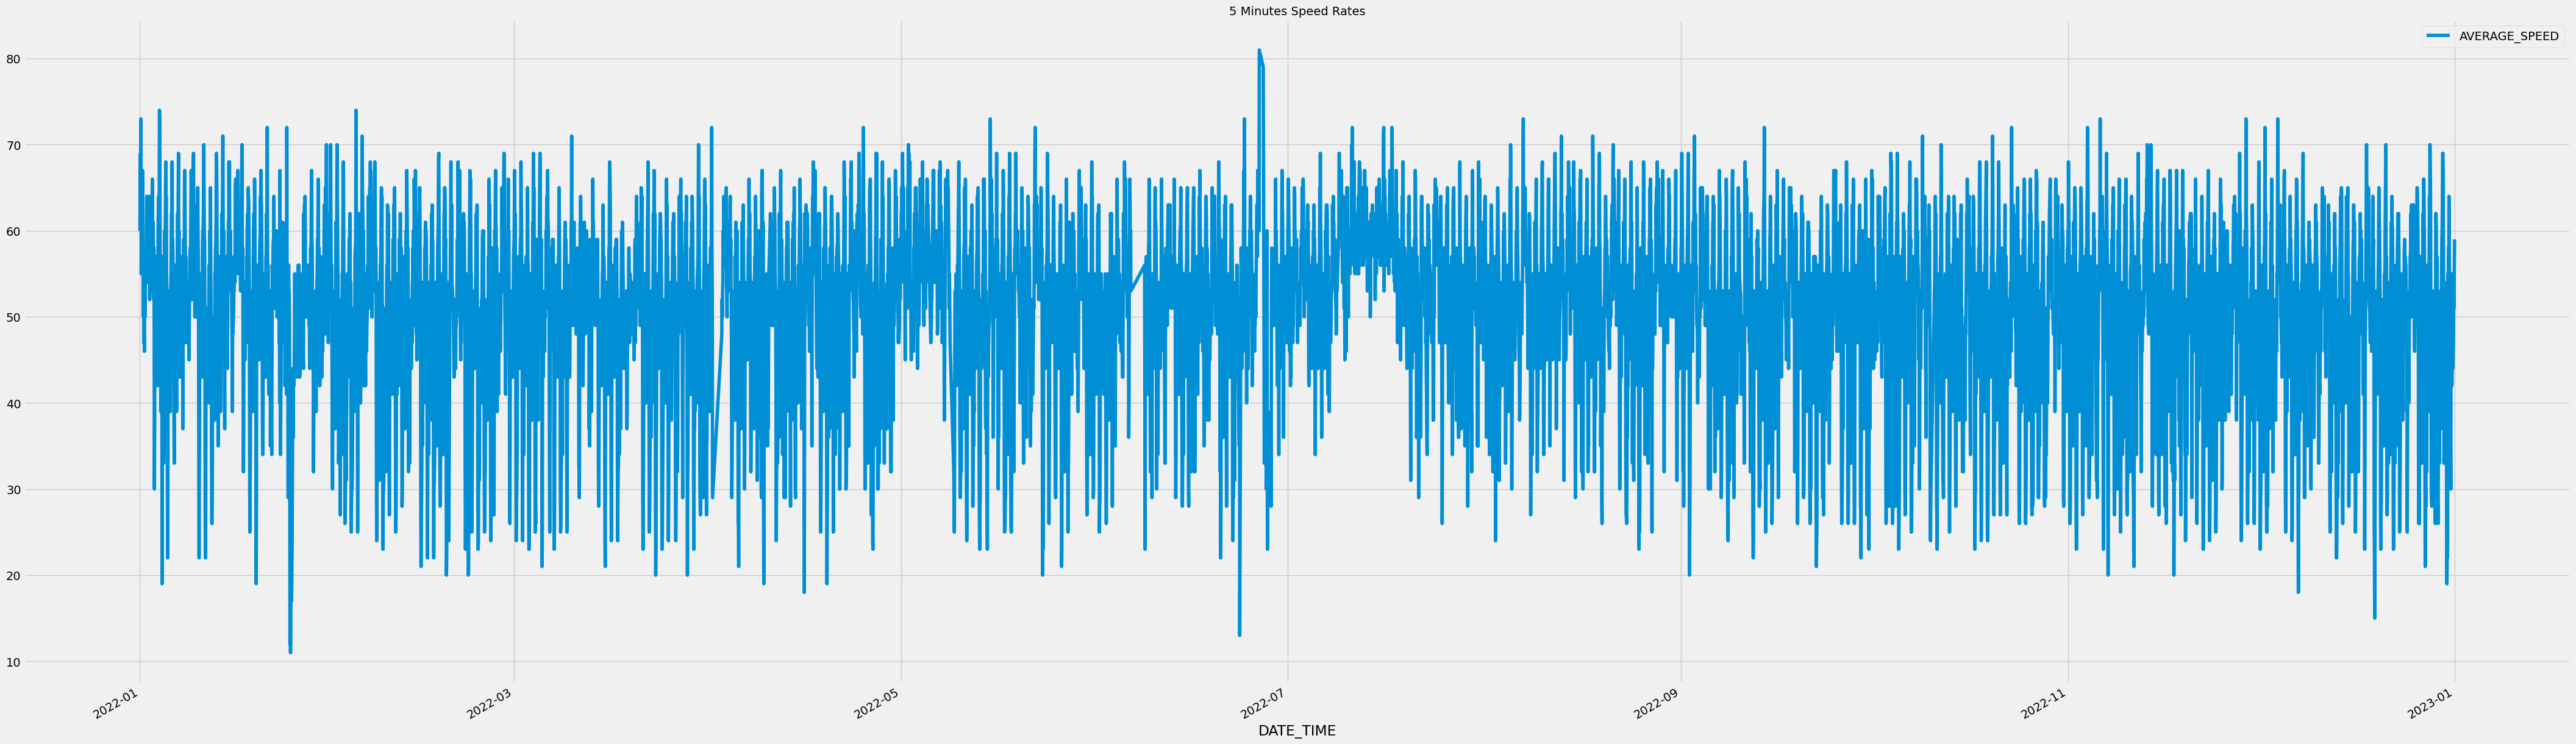

In [4]:
fig = plt.figure(figsize=(48,16))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('5 Minutes Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# CROSS VALIDATION DENEMEK ICIN BIRAKTIM

from numpy import array
from sklearn.model_selection import KFold
# prepare cross validation
#kfold = KFold(5, True, 1)
# enumerate splits
#for train, test in kfold.split(dataset):
# print('train: %s, test: %s' % (dataset[train], dataset[test]))

In [8]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Gün Sayıları (training set, test set): " + str((len(train), len(test))))
#dataset[train_size:len(dataset)]

Gün Sayıları (training set, test set): (5121, 3414)


In [9]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        tot = window_size + n_steps_out - 1
        for i in range(int((len(dataset) - tot))):
                start_a = i
                end_a = start_a + window_size
                start_b = end_a
                end_b = end_a + n_steps_out
                a = dataset[start_a:end_a, 0]
                b = dataset[start_b:end_b, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [10]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
train_X, train_Y = create_datasetMultiSteps(train,n_steps_out, window_size)
test_X, test_Y = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(5113, 6)


In [11]:
# Yeni verisetinin şekline bakalım.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

New training data shape:
(5113, 1, 6)


In [12]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.15))
model.add(Dense(n_steps_out))
model.compile(loss='mae', optimizer='adam')
model.fit(train_X, train_Y, epochs = 1000, batch_size = 32, validation_data=(test_X, test_Y), verbose=0, shuffle=False)

In [13]:
test_y = test_Y.reshape(-1,n_steps_out)
#x_test = test_X
train_y = train_Y.reshape(-1,n_steps_out)
#x_train = train_X

In [14]:
# make a prediction
pred_train_y = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], window_size))

# Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
pred_train_y = concatenate((train_X[:, -window_size:], pred_train_y), axis=1)
pred_train_y = scaler.inverse_transform(pred_train_y)
pred_train_y = pred_train_y[:,-n_steps_out:]

# invert scaling for actual

train_y = concatenate((train_X[:, -window_size:], train_y), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,-n_steps_out:]

160/160 [==============================] - 1s 1ms/step


In [15]:
# make a prediction
pred_test_y = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], window_size))

# invert scaling for forecast
pred_test_y = concatenate(( test_X[:, -window_size:], pred_test_y), axis=1)
pred_test_y = scaler.inverse_transform(pred_test_y)
pred_test_y = pred_test_y[:,-n_steps_out:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_y = concatenate((test_X[:, -window_size:], test_y), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,-n_steps_out:]

107/107 [==============================] - 0s 1ms/step


In [16]:
# calculate RMSE
rmse_train = sqrt(mean_squared_error(train_y, pred_train_y))
print("Train data score: %.2f RMSE" % rmse_train)

rmse_test = sqrt(mean_squared_error(test_y, pred_test_y))
print("Test data score: %.2f RMSE" % rmse_test)

Train data score: 8.01 RMSE
Test data score: 8.88 RMSE


In [17]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_y, pred_train_y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_y, pred_test_y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_y[:,0], pred_test_y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_y[:,1], pred_test_y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_y[:,2], pred_test_y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 13.51 MAPE
Test data score: 15.97 MAPE
Test t zamanı score: 11.64 MAPE
Test t+1 zamanı score: 16.92 MAPE
Test t+2 zamanı score: 19.36 MAPE


In [18]:
mdape_tr = np.median((np.abs(np.subtract(train_y, pred_train_y)/ train_y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_y, pred_test_y)/ test_y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 7.11 MdAPE
Test data score: 8.19 MdAPE


In [19]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_y, pred_train_y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_y, pred_test_y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 35.03 SMAPE
Test data score: 40.57 SMAPE


In [20]:
from sklearn.metrics import mean_absolute_error
e_tr = train_y - pred_train_y
scale = mean_absolute_error(train_y[1:], train_y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_y - pred_test_y
scale = mean_absolute_error(test_y[1:], test_y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 1.09 MASE
Test data score: 1.14 MASE


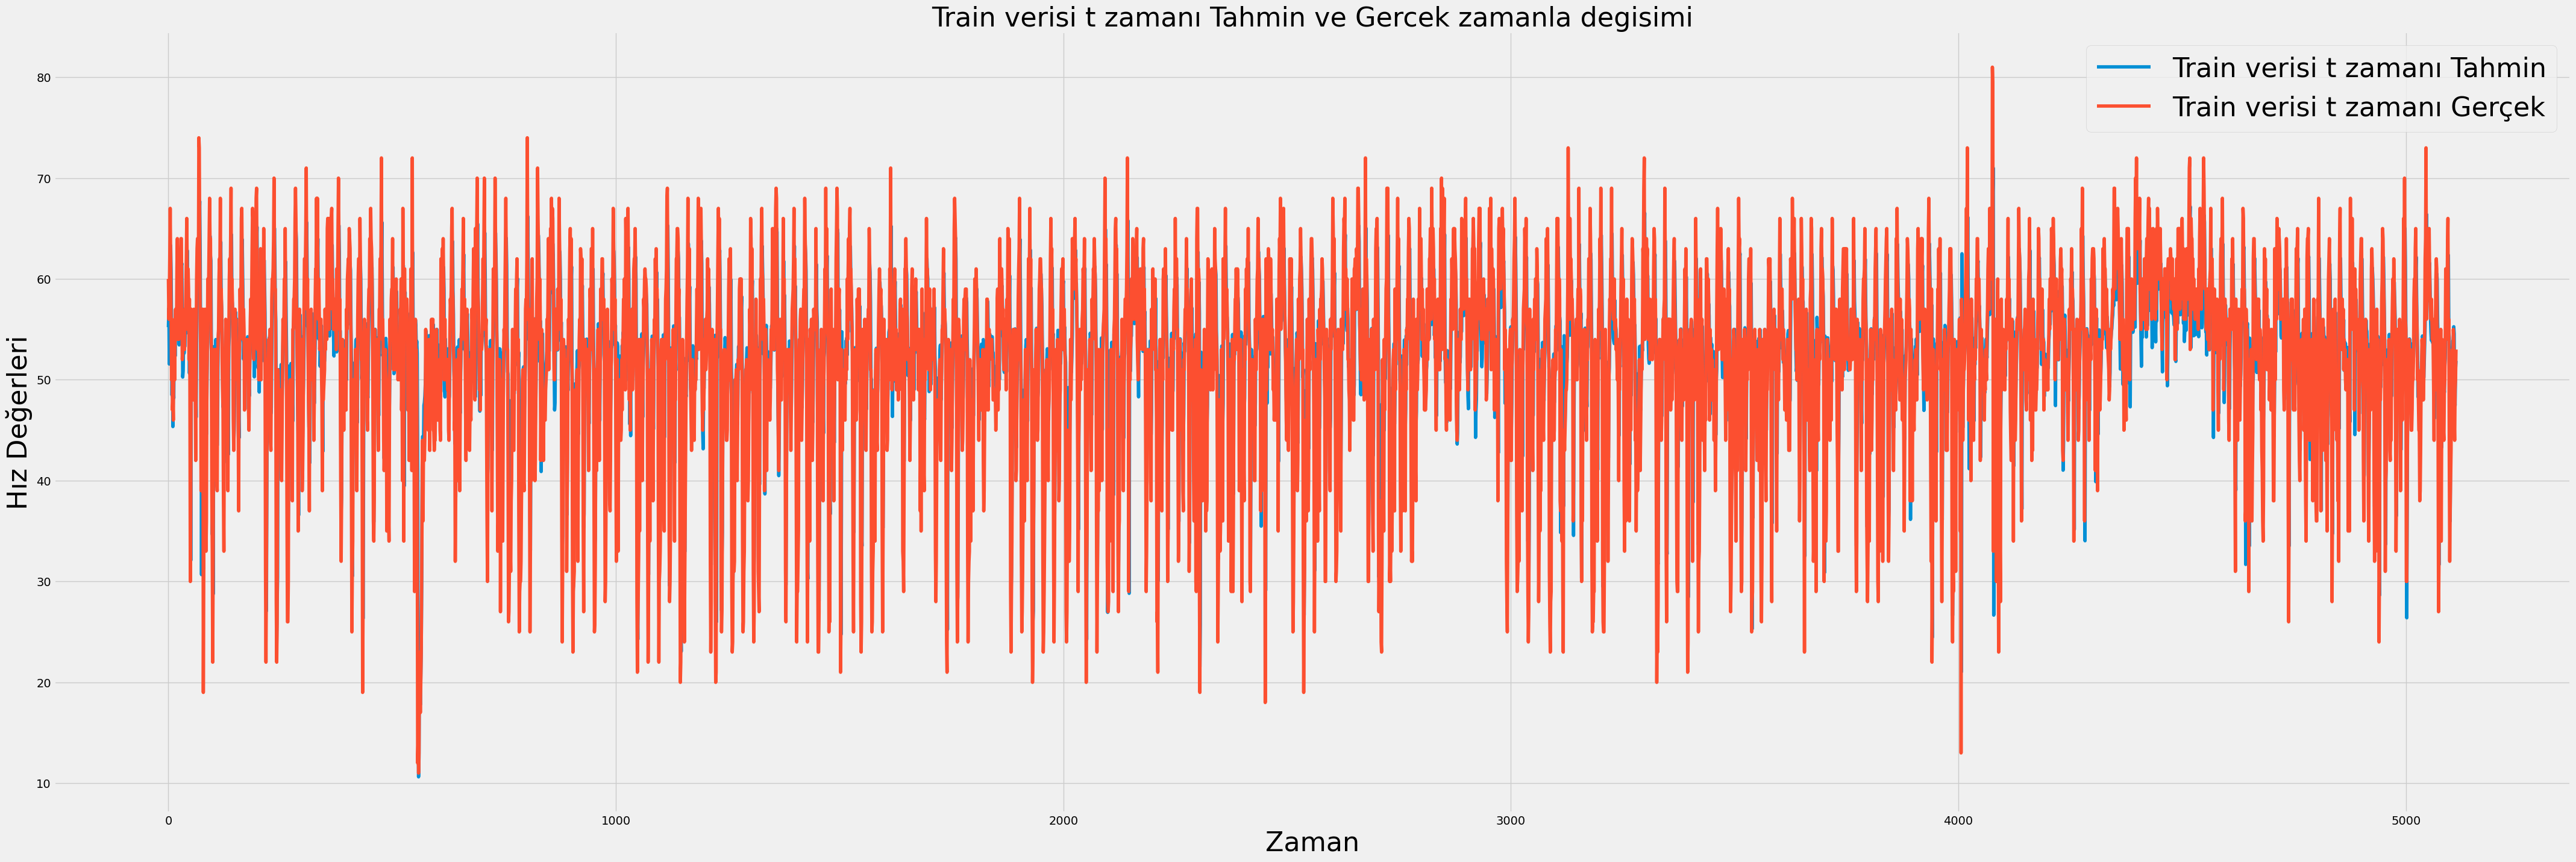

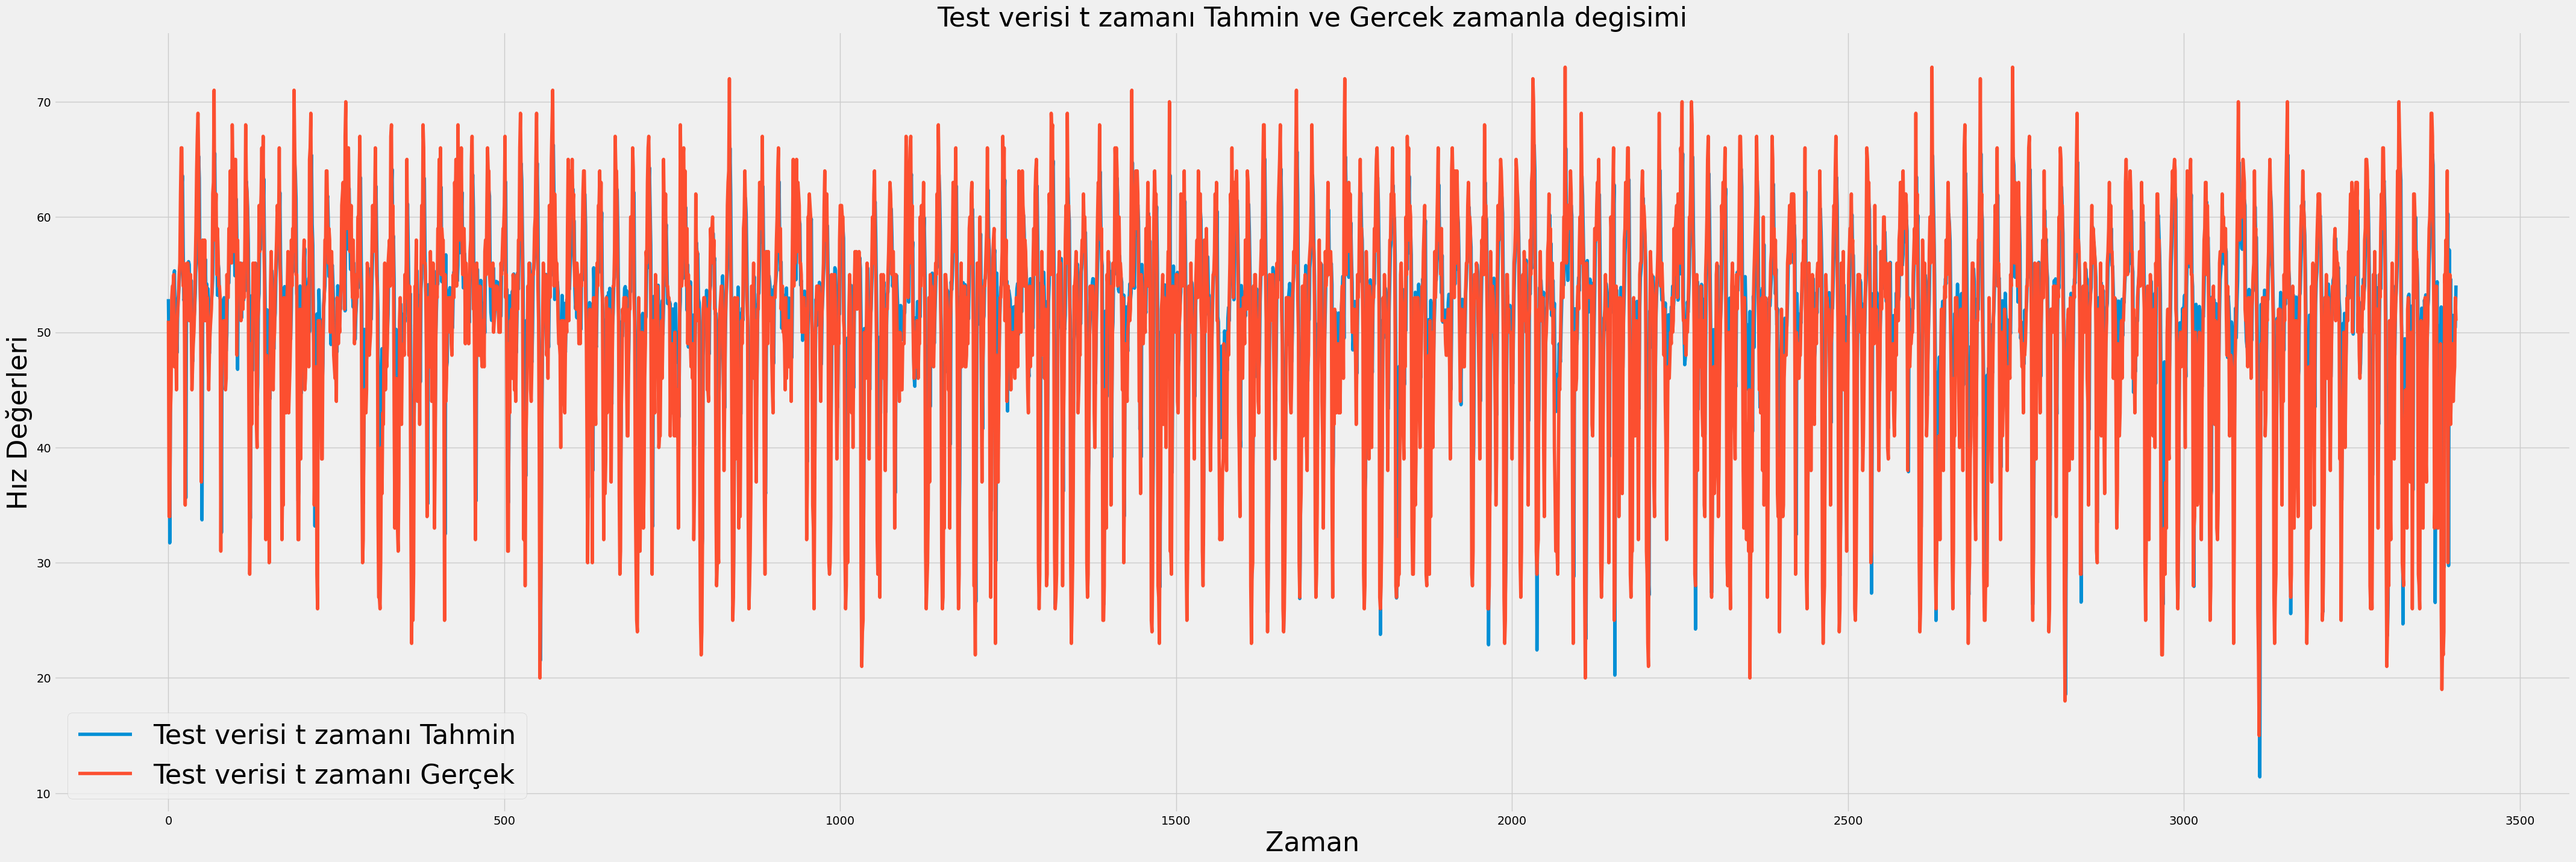

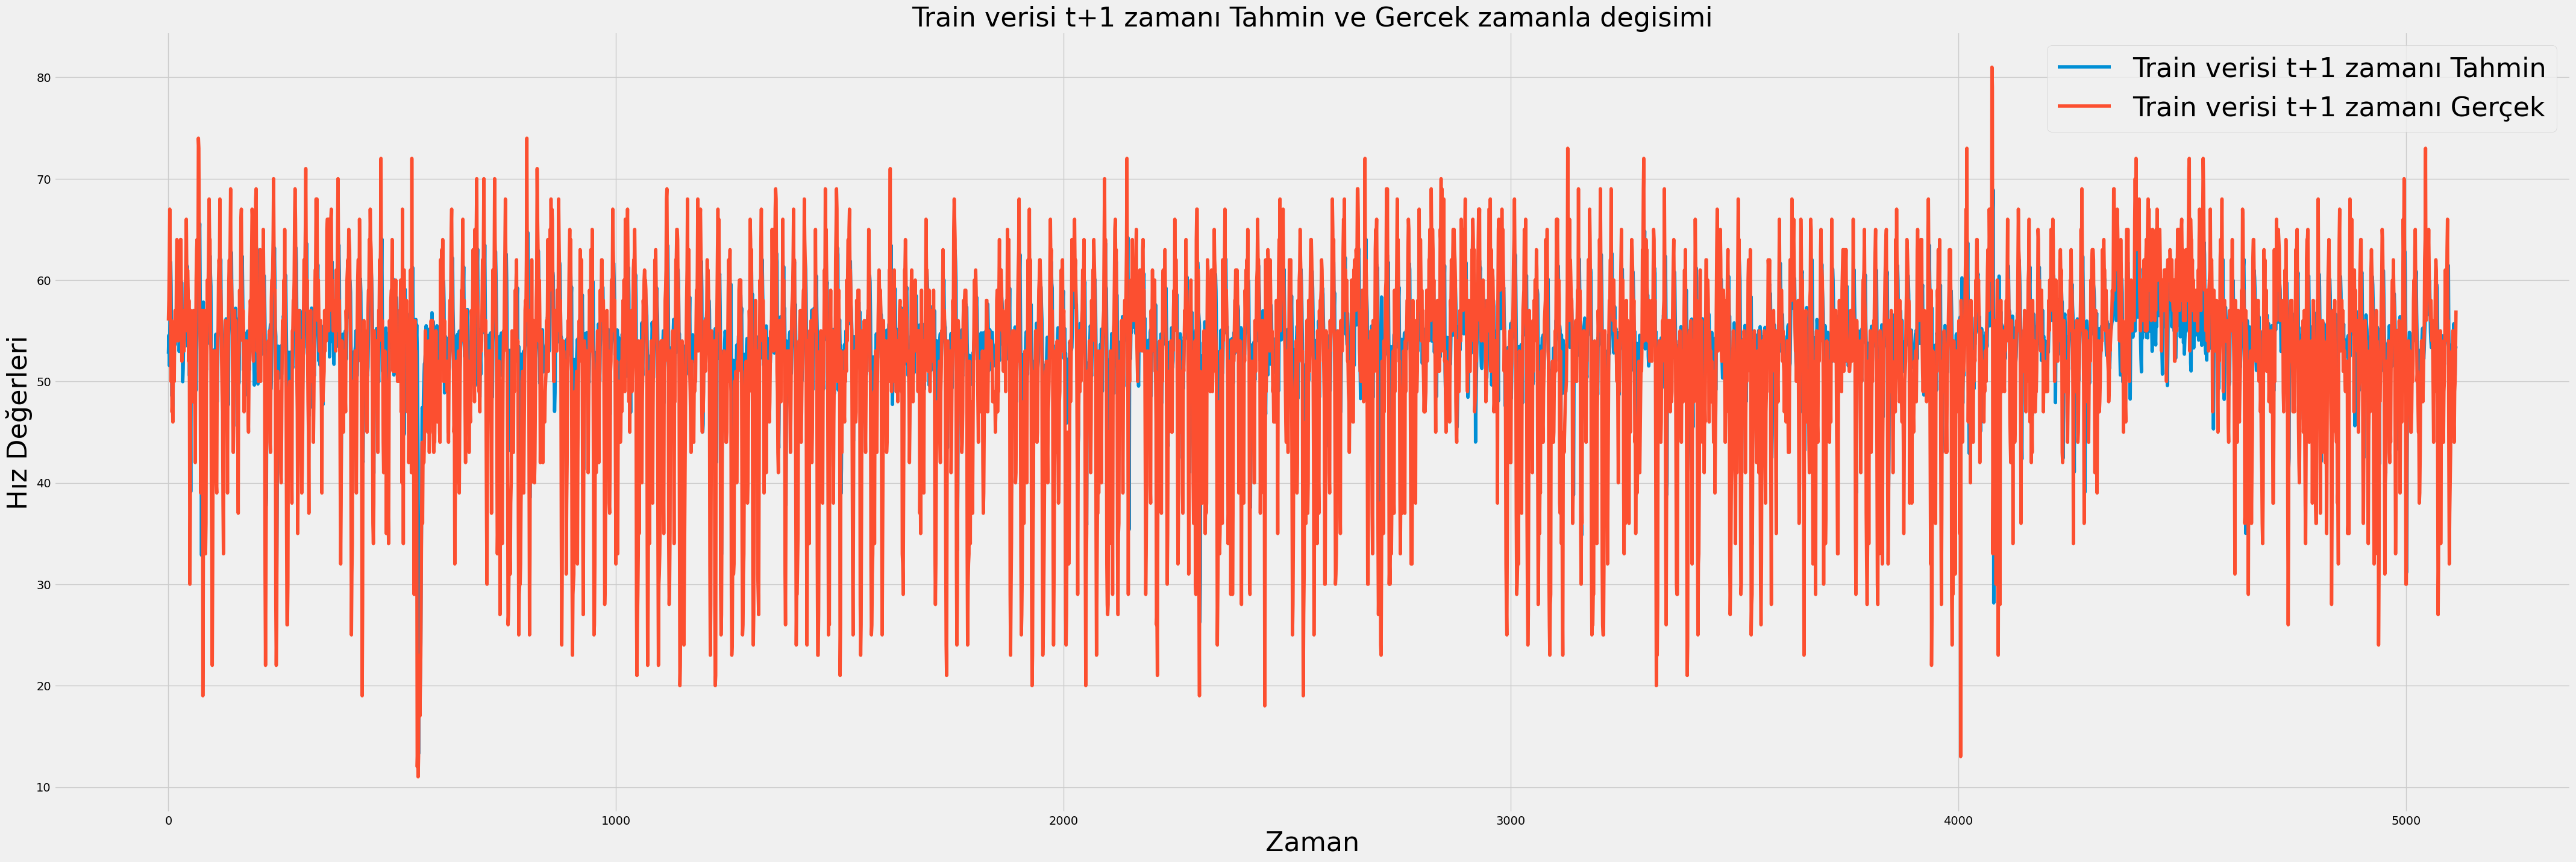

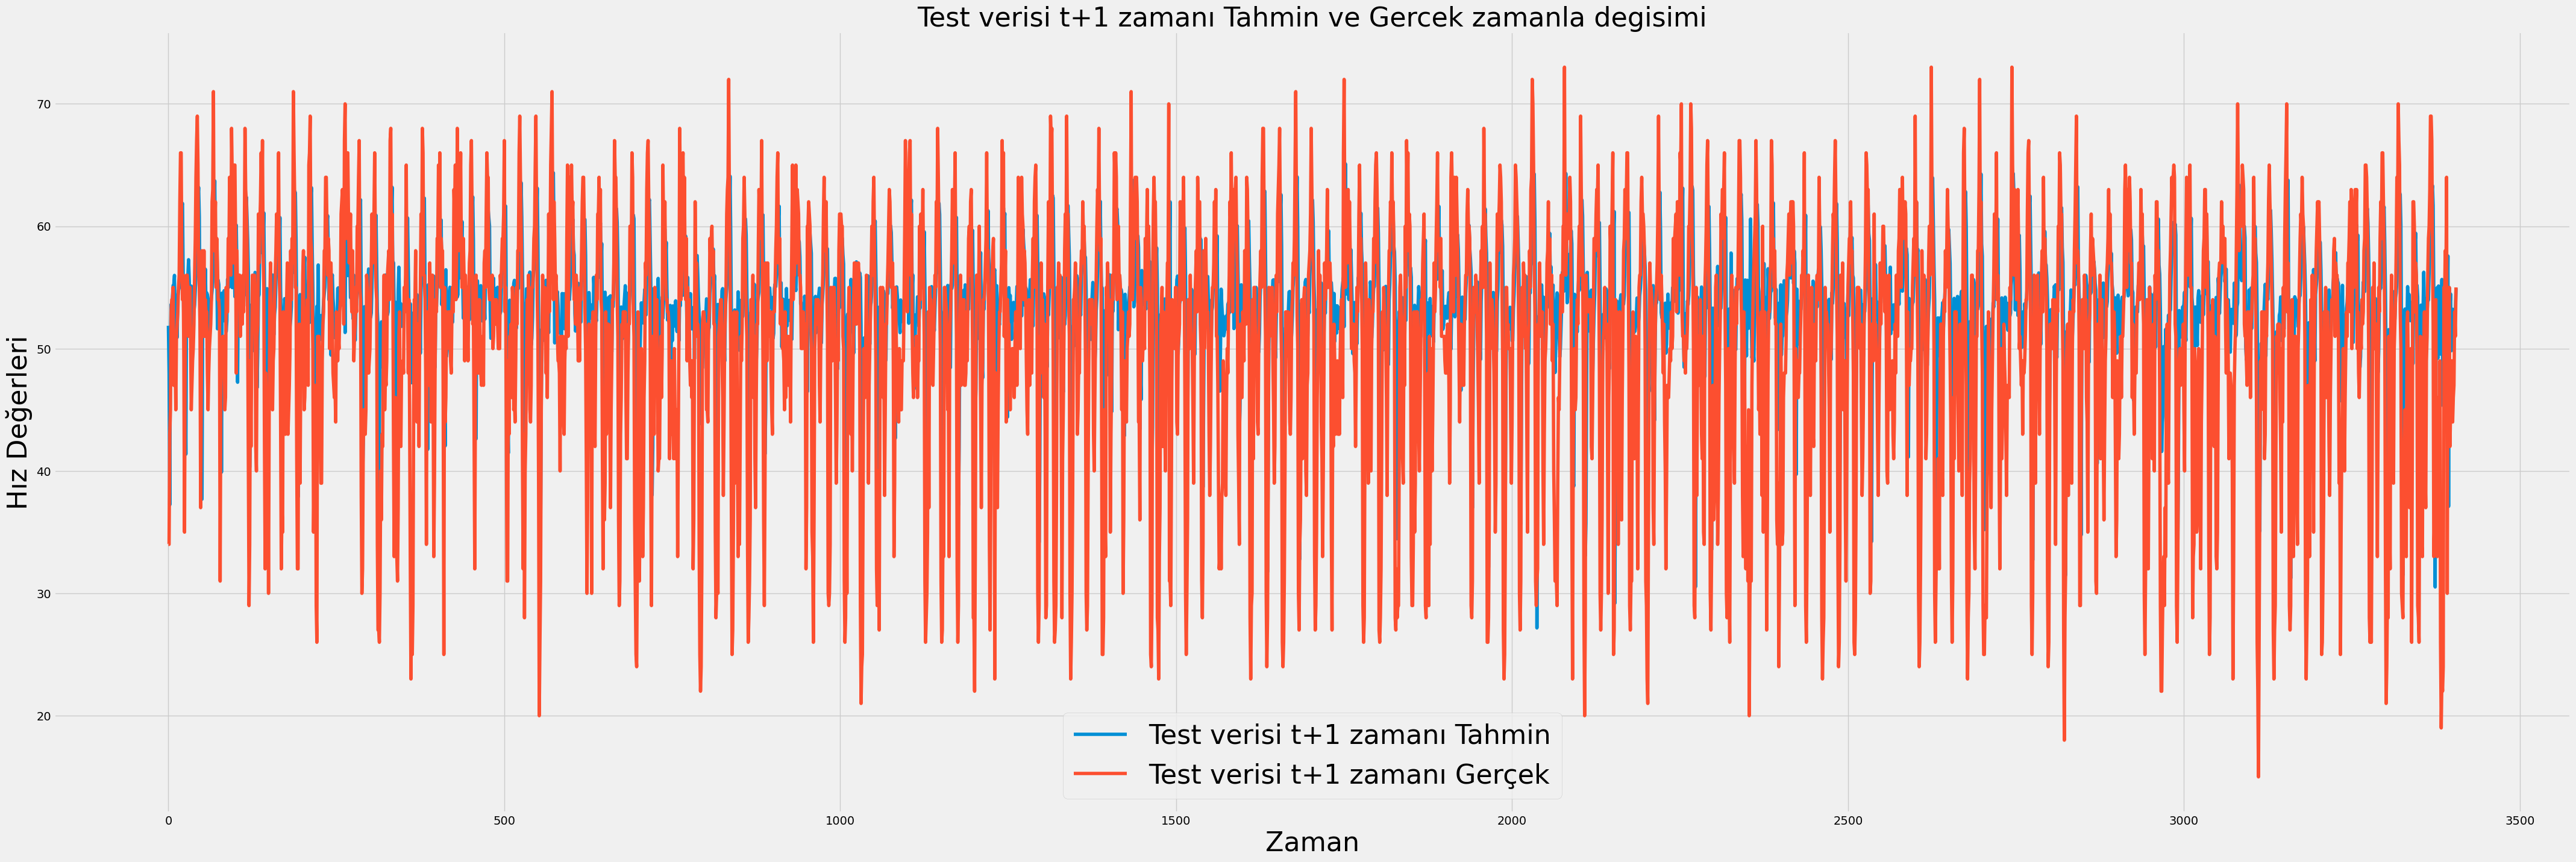

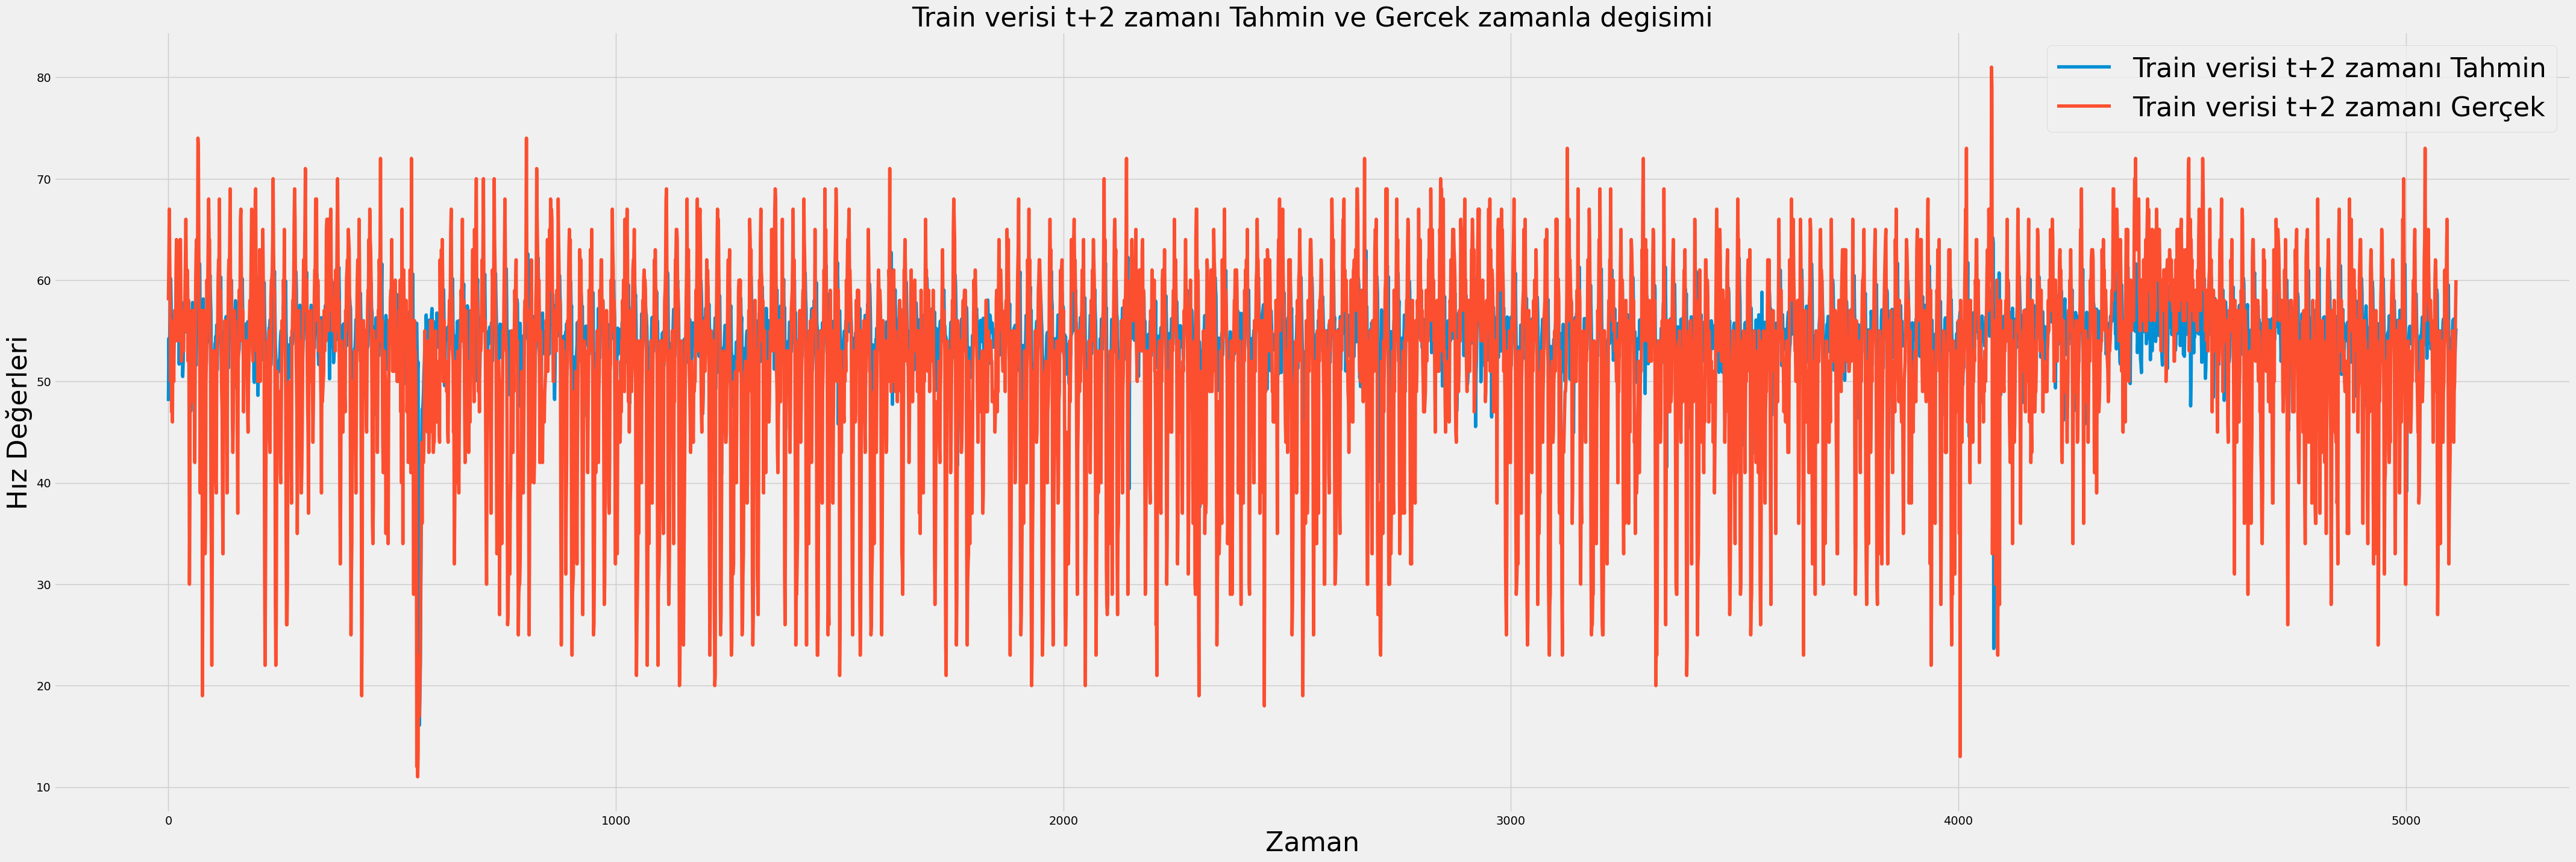

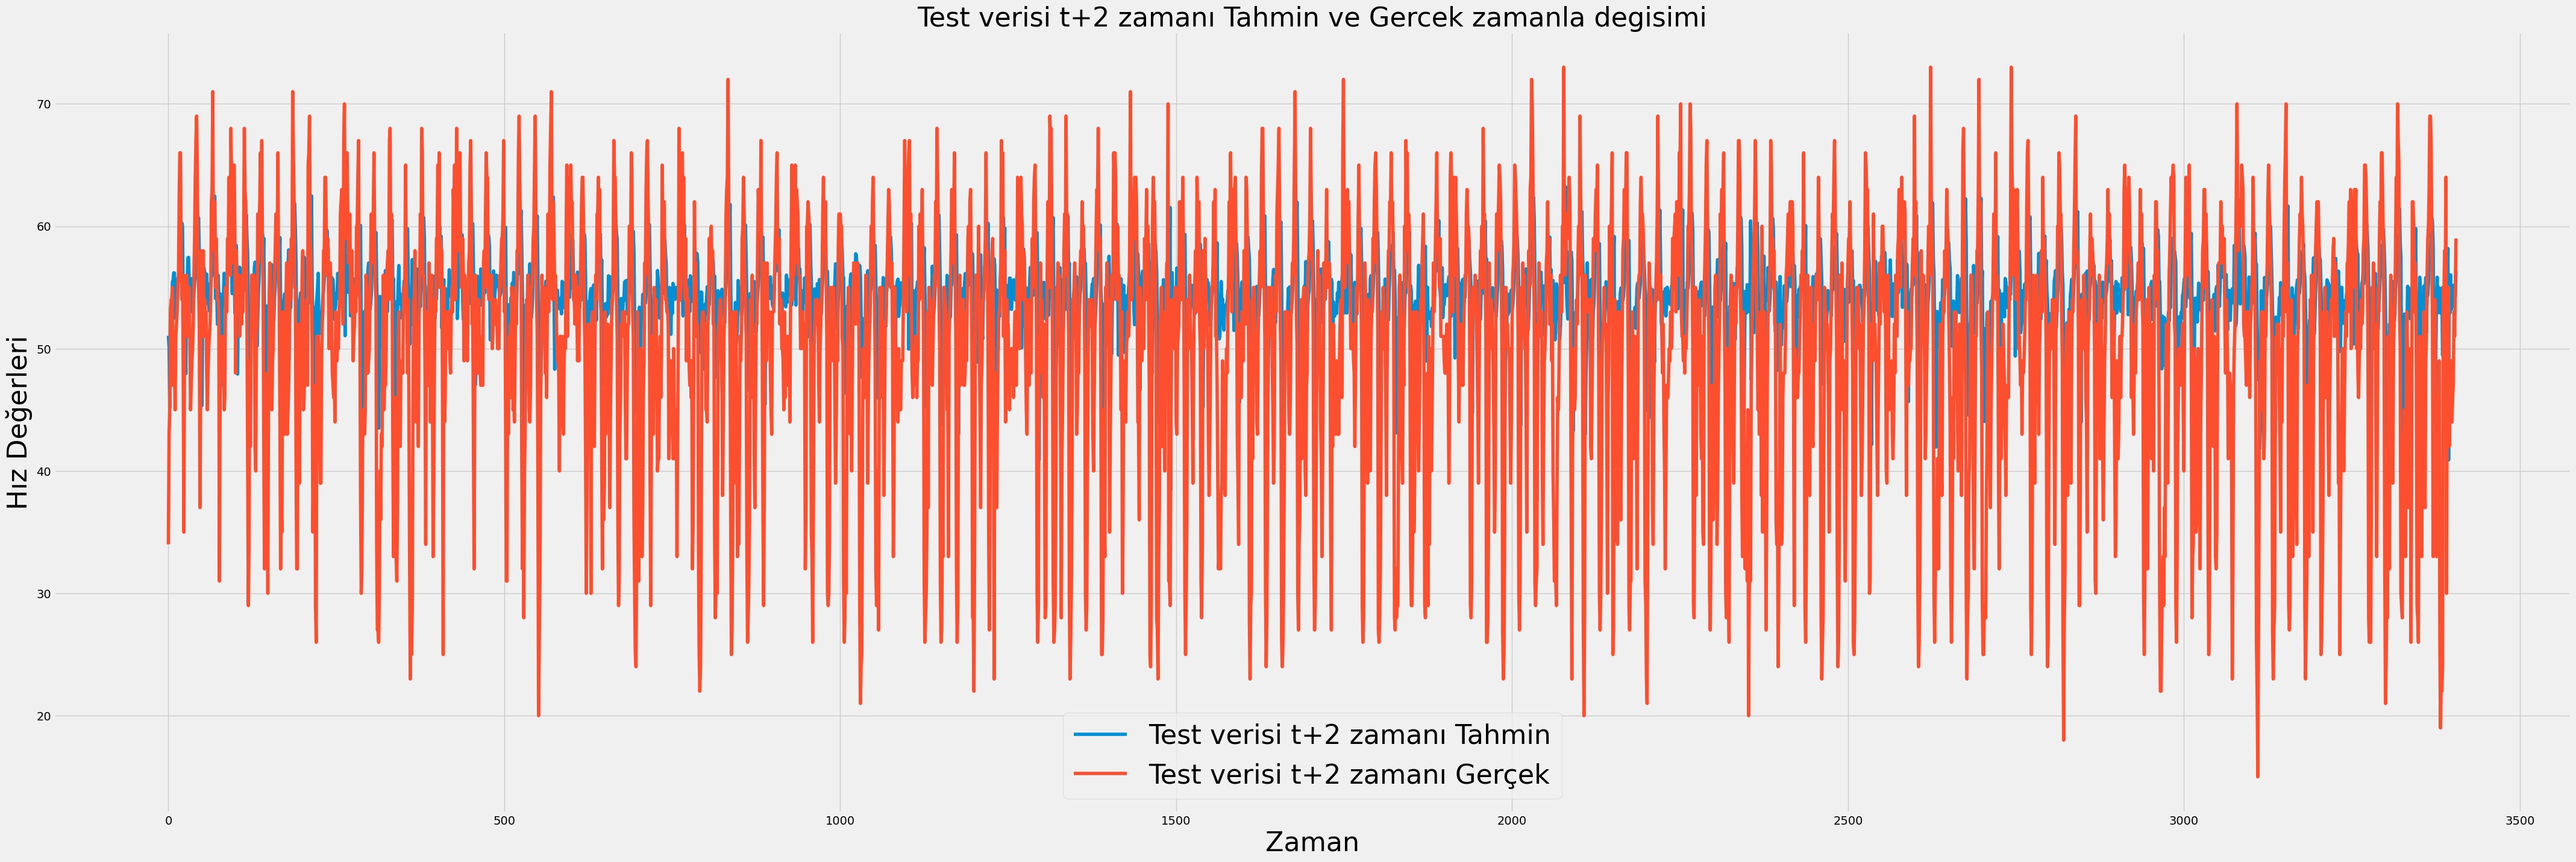

In [21]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')